In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 24.1 MB/s eta 0:00:00


In [ ]:
!apt-get install fonts-noto

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core fonts-noto-extra
  fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra fonts-noto-unhinted
The following NEW packages will be installed:
  fonts-noto fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core
  fonts-noto-extra fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra fonts-noto-unhinted
0 upgraded, 10 newly installed, 0 to remove and 49 not upgraded.
Need to get 317 MB of archives.
After this operation, 789 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto all 20201225-1build1 [16.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:2022

In [11]:
import cv2
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image as PILImage, ImageDraw, ImageFont
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import os


In [12]:
# Load YOLOv8 model using torch
model = YOLO('/content/best.pt')

# Load TrOCR model and processor for OCR
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
ocr_model = VisionEncoderDecoderModel.from_pretrained('/content/drive/MyDrive/ocr/seq2seq_model_printed/checkpoint-4150')

input_folder = "/content/test"  # Path to the folder containing images
output_file = "/content/results.txt"
output_folder = "/content/processed_images"  # Folder to save processed images
os.makedirs(output_folder, exist_ok=True)


Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

In [13]:
# Preprocess image for OCR model (convert OpenCV image to PIL)
def preprocess_for_ocr(plate_img):
    # Convert OpenCV Mat (BGR) to RGB format and then to PIL image
    pil_img = PILImage.fromarray(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
    return pil_img


In [14]:
# Decode the OCR predictions
def decode_predictions(ocr_inputs):
    pixel_values = processor(images=ocr_inputs, return_tensors="pt").pixel_values
    generated_ids = ocr_model.generate(pixel_values)
    plate_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(plate_text)
    return plate_text.strip()


In [15]:
# Draw Arabic text on an OpenCV image using PIL
def draw_arabic_text(image, text, position, font_path="/usr/share/fonts/truetype/arabic/NotoNaskhArabic-Regular.ttf", font_size=20, color=(0, 255, 0)):
    # Convert OpenCV image (BGR) to PIL Image (RGB)
    pil_image = PILImage.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)

    # Load the font for Arabic text rendering
    font = ImageFont.truetype(font_path, font_size)

    # Draw the text on the image
    draw.text(position, text, font=font, fill=color)

    # Convert the PIL Image back to OpenCV format (BGR)
    return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)



0: 640x448 2 licence Plates, 31.9ms
Speed: 4.9ms preprocess, 31.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)
ص ب ه 1379
ص ب ه 1379
Processed test5.jpg and saved to /content/processed_images/processed_test5.jpg


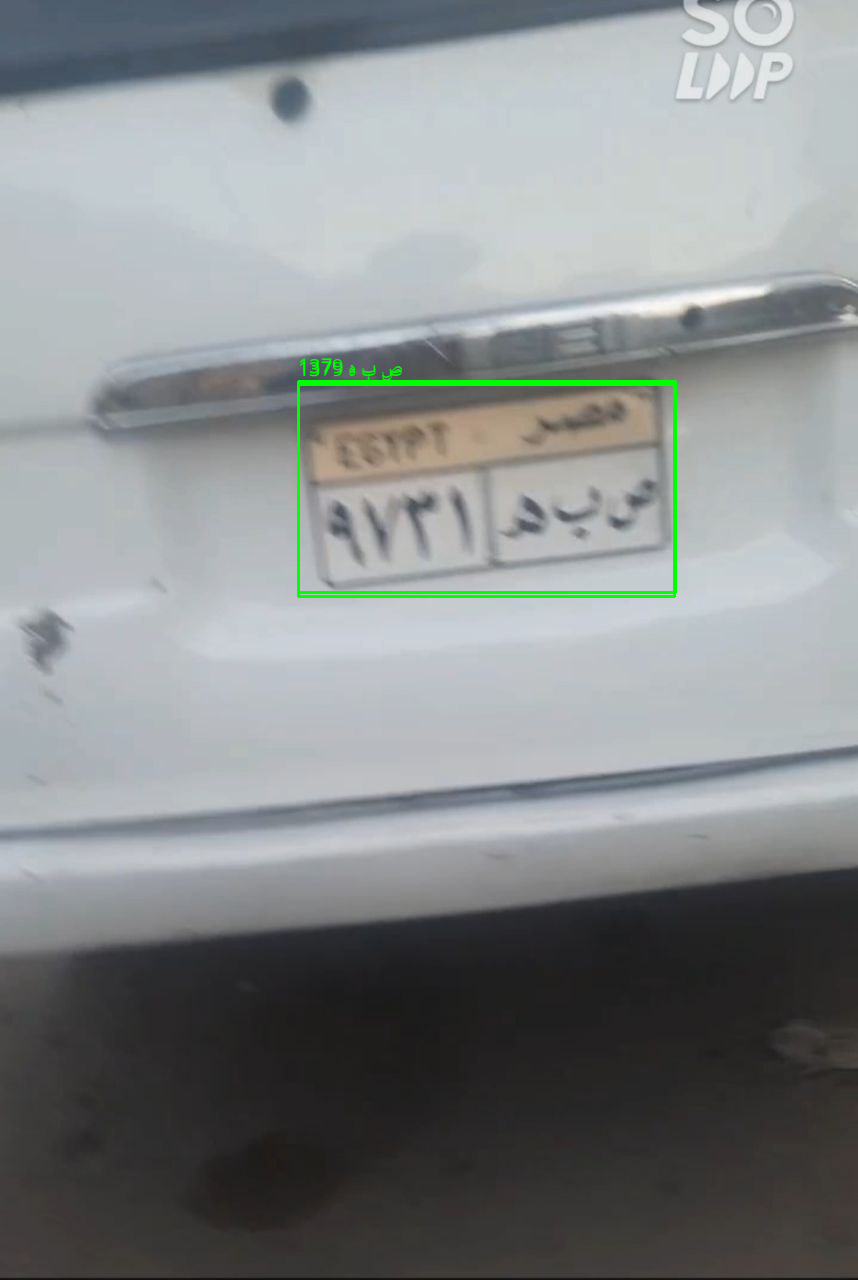

Failed to read image: .ipynb_checkpoints

0: 640x320 1 licence Plate, 15.6ms
Speed: 2.7ms preprocess, 15.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)
س ط م 4596
Processed test6.jpg and saved to /content/processed_images/processed_test6.jpg


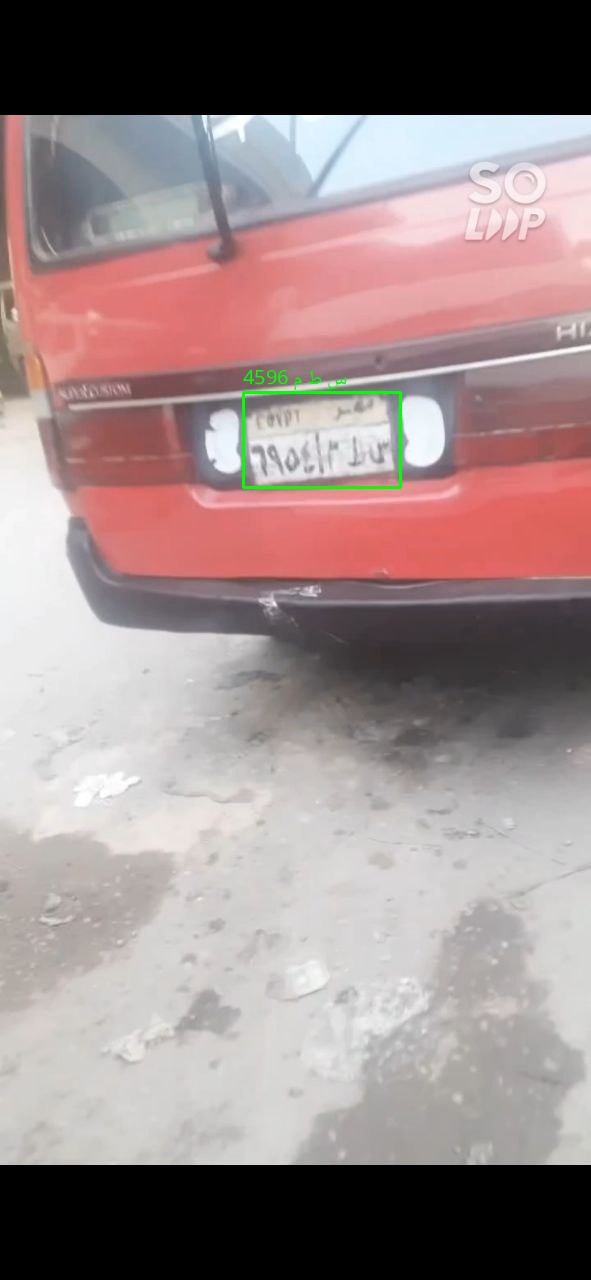


0: 640x320 1 licence Plate, 19.7ms
Speed: 2.9ms preprocess, 19.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)
س ل ج 5197
Processed test2.jpg and saved to /content/processed_images/processed_test2.jpg


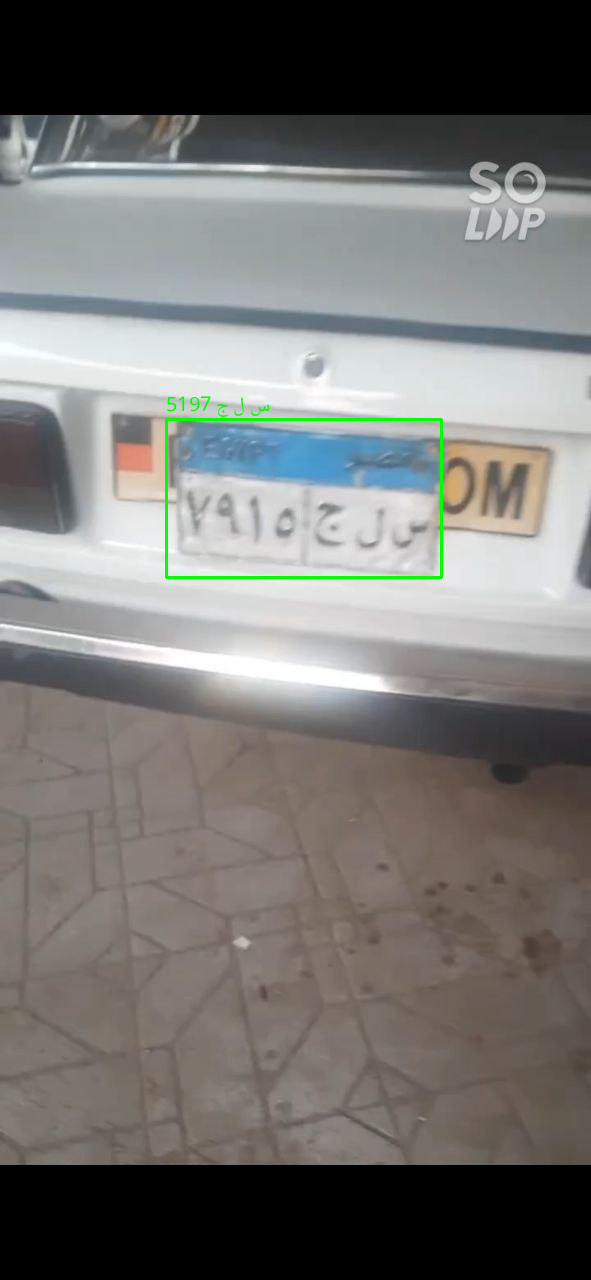

In [17]:
# Iterate through all images in the input folder
with open(output_file, 'w') as writer:
    for image_name in os.listdir(input_folder):
        image_path = os.path.join(input_folder, image_name)

        # Read the image
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"Failed to read image: {image_name}")
            continue

        # Convert frame to RGB and resize to 640x640 for YOLO model
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = model(frame_rgb)

        # Get detected bounding boxes
        boxes = results[0].boxes  # Extract the boxes object
        for box in boxes:
            # Extract coordinates and confidence from the box
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            conf = box.conf.item()
            class_id = box.cls.item()

            # Crop the detected license plate region
            plate_img = frame[y1:y2, x1:x2]

            # Preprocess the plate image for the OCR model
            preprocessed_plate = preprocess_for_ocr(plate_img)
            # Perform OCR using the TrOCR model
            plate_text = decode_predictions(preprocessed_plate)

            # Write the result to the output file
            writer.write(f"Image {image_name}: Detected plate - {plate_text}\n")

            # Draw the bounding box on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Draw the Arabic text on the frame
            frame = draw_arabic_text(frame, plate_text, (x1, y1 - 30))

        # Save the processed image
        processed_image_path = os.path.join(output_folder, f"processed_{image_name}")
        cv2.imwrite(processed_image_path, frame)

        print(f"Processed {image_name} and saved to {processed_image_path}")
        # Display the frame with the detected bounding boxes
        cv2_imshow(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

